Использую датасет Caltech-101 для классификации.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
batch_size = 32
learning_rate = 0.001
num_epochs = 20
train_val_split = 0.8

Аугементация + Нормализация

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.Caltech101(
    root="./data",
    download=True,
    transform=transform,)

train_size = int(len(dataset) * train_val_split)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=41f250aa-1e6d-450b-9078-583684b608d8
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 103MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=c25f38b7-30a7-4384-9ab0-8e6993847a07
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 59.3MB/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


In [5]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 102)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        accuracy = correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Accuracy: {accuracy:.4f}")

    return train_losses, val_losses, best_accuracy


train_losses, val_losses, best_accuracy = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs)

print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Epoch [1/20], Train Loss: 1.7279, Val Loss: 1.1261, Accuracy: 0.7114
Epoch [2/20], Train Loss: 0.7842, Val Loss: 1.0740, Accuracy: 0.7218
Epoch [3/20], Train Loss: 0.5051, Val Loss: 0.8725, Accuracy: 0.7696
Epoch [4/20], Train Loss: 0.3492, Val Loss: 0.9419, Accuracy: 0.7702
Epoch [5/20], Train Loss: 0.2790, Val Loss: 0.7516, Accuracy: 0.8030
Epoch [6/20], Train Loss: 0.1801, Val Loss: 0.7650, Accuracy: 0.8047
Epoch [7/20], Train Loss: 0.1753, Val Loss: 0.6712, Accuracy: 0.8203
Epoch [8/20], Train Loss: 0.1637, Val Loss: 0.7561, Accuracy: 0.8226
Epoch [9/20], Train Loss: 0.1109, Val Loss: 0.6153, Accuracy: 0.8520
Epoch [10/20], Train Loss: 0.1114, Val Loss: 0.6551, Accuracy: 0.8468
Epoch [11/20], Train Loss: 0.0900, Val Loss: 0.6020, Accuracy: 0.8468
Epoch [12/20], Train Loss: 0.0898, Val Loss: 0.6819, Accuracy: 0.8364
Epoch [13/20], Train Loss: 0.1157, Val Loss: 0.5214, Accuracy: 0.8715
Epoch [14/20], Train Loss: 0.0952, Val Loss: 0.6834, Accuracy: 0.8462
Epoch [15/20], Train Loss: 0.

Не получилось добиться точности 90+, однако была достаточно близко к этому.

Смотрим, какие классы есть в датасете вообще

In [8]:
class_names = dataset.categories
class_names

['Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'sc

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')


def visualize_classification_results(model, dataloader, class_names, num_images=8):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(20, 8))
    for i in range(num_images):
        ax = fig.add_subplot(2, num_images // 2, i + 1, xticks=[], yticks=[])
        imshow(images[i].cpu(), title=f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
    plt.show()

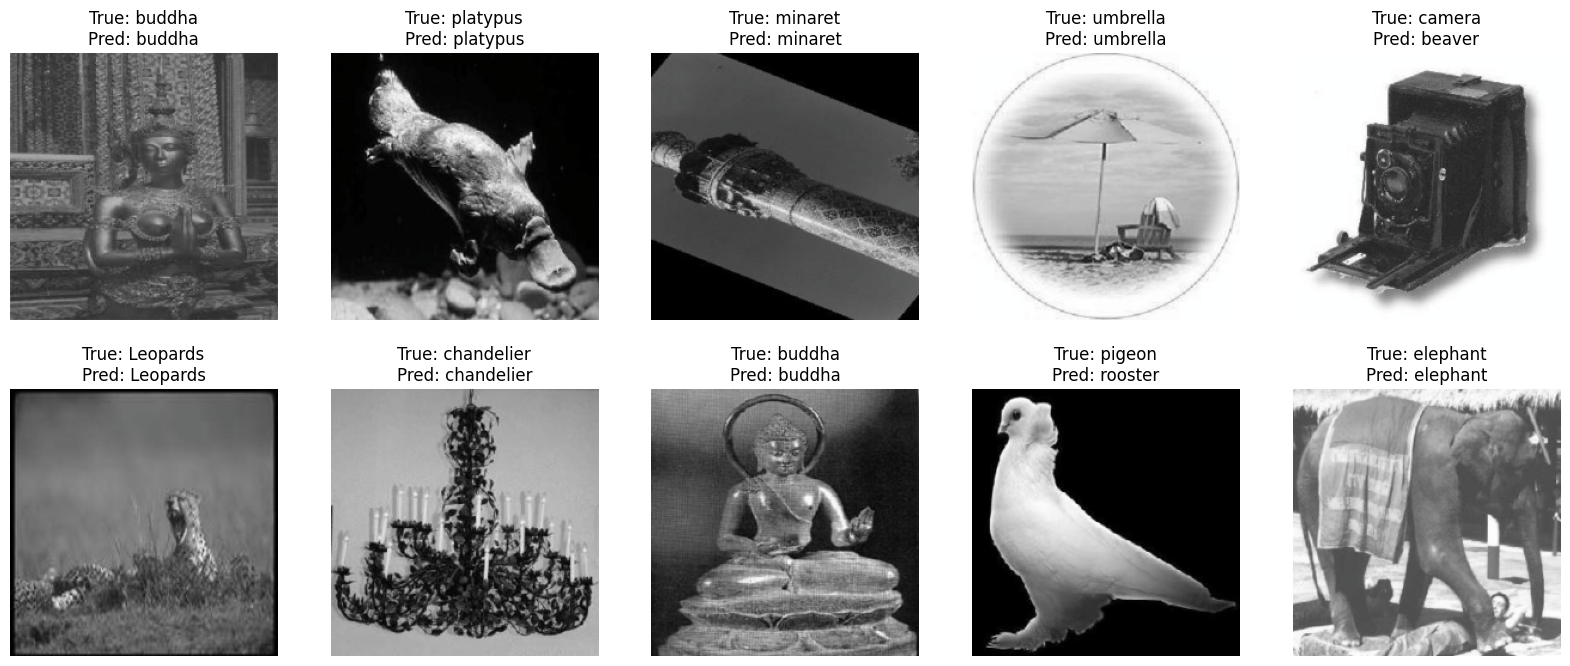

In [10]:
visualize_classification_results(model, val_loader, class_names, num_images=10)

Да, ошибки есть, но в 8/10 случае срабатывает верно. Кроме того, пятый случай достаточно нетривиальный.